In [5]:
import pandas as pd
import os
import glob
# from cuml import TSNE, UMAP
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE as sklearn_tsne
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu
home = '/home/eloiseb/stanford_drive/data/Exosome/'
home = "/Users/eloiseberson/Google Drive/My Drive/data/Exosome/"

In [15]:
os.listdir(home + "Cohort Runs/Panel 1/")

['Panel 1 - Disabled Spots',
 'Panel 1 - Run data',
 'Panel 1 - Cut-Offs',
 'Panel 1 - Single-Particle data']

In [24]:
# load groundtruth
gt = pd.read_excel(os.path.join(home,'TPAD_CSF EV samples_koya.xlsx'))
gt = gt.loc[:, ['TPAD ID', 'Linkcode', 'Cohort', 'Diagnosis', 'PID 1-90']]
gt['PID 1-90'] = gt['PID 1-90'].astype('str')
gt

/Users/eloiseberson/anaconda3/envs/jupyter/lib/python3.10/site-packages/openpyxl/reader/workbook.py:118: UserWarning: Print area cannot be set to Defined name: Table1[#All].
  warn(f"Print area cannot be set to Defined name: {defn.value}.")


,TPAD ID,Linkcode,Cohort,Diagnosis,PID 1-90
0,TPAD0473,141236,Poston,HC,1
1,TPAD0450,141091,Poston,HC,2
2,TPAD0494,141370,Poston,HC,3
3,TPAD0490,141361,Poston,HC,4
4,TPAD0471,141229,Poston,HC,5
...,...,...,...,...,...
85,TPAD0479,141312,Poston,PD-noMCI,86
86,TPAD0488,141352,Poston,PD-noMCI,87
87,TPAD0298,1013,ADRC,PD-noMCI,88
88,TPAD0318,1072,ADRC,PD-noMCI,89


In [28]:
# load data
dico_panel2marker = {1:"A-Beta", 2:"Tau-5", 3:"A-Syn",4:"ApoE"}
df_tot = []
panel_id = 1
for panel_id in [1,2,3,4]:
    print(panel_id)
    panel_dir = os.path.join(home,'Cohort Runs',"Panel %s"%str(panel_id), 'Panel %s - Single-Particle data'%(str(panel_id)))
    file_list = [i for i in glob.glob(panel_dir+ "/Run */*") if '001_TotalParticles-' in i]
    data_dict = {str(i)+'_'+str(k):v for i,d in enumerate([pd.read_excel(os.path.join(panel_dir, filename), sheet_name=None, header=None) for filename in file_list]) for k,v in d.items()}
    data_dict = {i:data_dict[i] for i in data_dict.keys() if all([j not in i for j in ['Parameters', 'Subpopulations']])}

    # join data into a dataframe
    data_list = []

    for person in data_dict.keys():
        data_sample = [data_dict[person].iloc[:, i*5:(i*5+5)].transpose().reset_index(drop=True).transpose() for i in range(int(data_dict[person].shape[1]/5))]
        data_sample = [d.iloc[1:, :] for d in data_sample]
        data_sample = [d[~d.isna().all(axis=1)] for d in data_sample]

        for i in range(len(data_sample)):
            data_sample[i].loc[:,5] = data_sample[i].iloc[0,1]
            data_sample[i].loc[:,0] = data_sample[i].loc[:,0].fillna(method="ffill")
            data_sample[i].columns = ['spot'] + data_sample[i].iloc[1,1:5].tolist() + ['marker']
            data_sample[i] = data_sample[i].iloc[2:,:]

        data_df = pd.concat(data_sample, axis=0)
        #filter by size
        data_exo = data_df.loc[(data_df.IM>=50) & (data_df.IM<=200), :].reset_index(drop=True)
        data_exo.loc[:, 'samples'] = person
        data_list += [data_exo]

    df = pd.concat(data_list, axis=0).reset_index(drop=True)
    df[['batch', 'samples']] = df.samples.str.split('_', expand=True)
    df["panel"] = panel_id


    df[[dico_panel2marker[panel_id],'CD47','PrP','IM']] = df.loc[:, [dico_panel2marker[panel_id],'CD47','PrP','IM']].astype('float')
    df_tot.append(df)

1


In [29]:
df = pd.concat(df_tot)
df_merge = df.merge(gt, left_on='samples', right_on='PID 1-90', how='left')

df_merge

,spot,A-Beta,CD47,PrP,IM,marker,samples,batch,panel,TPAD ID,Linkcode,Cohort,Diagnosis,PID 1-90
0,Spot4,0.0,0.0,765.0,59.652542,CD63,30,0,1,TPAD0373,1229,ADRC,HC,30
1,Spot4,0.0,0.0,0.0,50.259791,CD63,30,0,1,TPAD0373,1229,ADRC,HC,30
2,Spot4,0.0,0.0,0.0,50.033887,CD63,30,0,1,TPAD0373,1229,ADRC,HC,30
3,Spot4,0.0,0.0,3300.0,54.698704,CD63,30,0,1,TPAD0373,1229,ADRC,HC,30
4,Spot4,0.0,0.0,0.0,58.245653,CD63,30,0,1,TPAD0373,1229,ADRC,HC,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1525658,Spot12,0.0,0.0,0.0,50.427757,MIgG,Pooled Control,5,1,NaN,NaN,NaN,NaN,NaN
1525659,Spot12,0.0,0.0,0.0,62.680279,MIgG,Pooled Control,5,1,NaN,NaN,NaN,NaN,NaN
1525660,Spot12,0.0,0.0,0.0,62.413525,MIgG,Pooled Control,5,1,NaN,NaN,NaN,NaN,NaN
1525661,Spot12,0.0,0.0,0.0,60.171432,MIgG,Pooled Control,5,1,NaN,NaN,NaN,NaN,NaN


In [30]:
df.samples.unique()

array(['30', '59', '66', '47', '72', '5', '50', '22', '51', '88', '27',
       '48', '89', 'Pooled Control', '18', '36', '62', '7', '44', '84',
       '2', '46', '86', '28', '34', '68', '29', '31', '65', '1', '58',
       '78', '19', '35', '85', '15', '33', '69', '17', '42', '71', '13',
       '37', '79', '53', '74', '8', '45', '80', '26', '49', '64', '11',
       '56', '63', '24', '52', '76', '9', '60', '87', '12', '38', '3',
       '39', '82', '23', '43', '61', '10', '41', '77', '14', '55', '67',
       '20', '57', '81', '4', '40', '83', '16', '54', '90', '21', '32'],
      dtype=object)

<AxesSubplot:xlabel='panel', ylabel='0'>

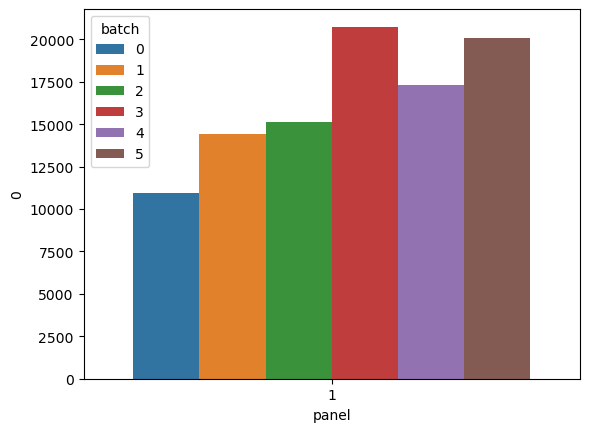

In [32]:
control = df[df.samples == "Pooled Control"]
cont_size = control.groupby(["panel", "batch"]).size().reset_index()
sns.barplot(data=cont_size, x="panel", y=0, hue="batch")

# Remove Pooled Control

In [45]:
# distribution plots by batch and by groups
marker = ['A-Beta', 'CD47', 'PrP', "Tau-5"]
groupby_cols = ['panel', 'samples', "marker"]
df_plt = (df.groupby(groupby_cols)[marker].apply(lambda x: (x>0).sum())/df.groupby(groupby_cols).count().loc[:, marker]*100).reset_index()
df_plt = df_plt.melt(groupby_cols)
df_plt.head(3)

,panel,samples,marker,variable,value
0,1,1,CD63,A-Beta,0.793280
1,1,1,CD81,A-Beta,1.624797
2,1,1,CD9,A-Beta,2.090517


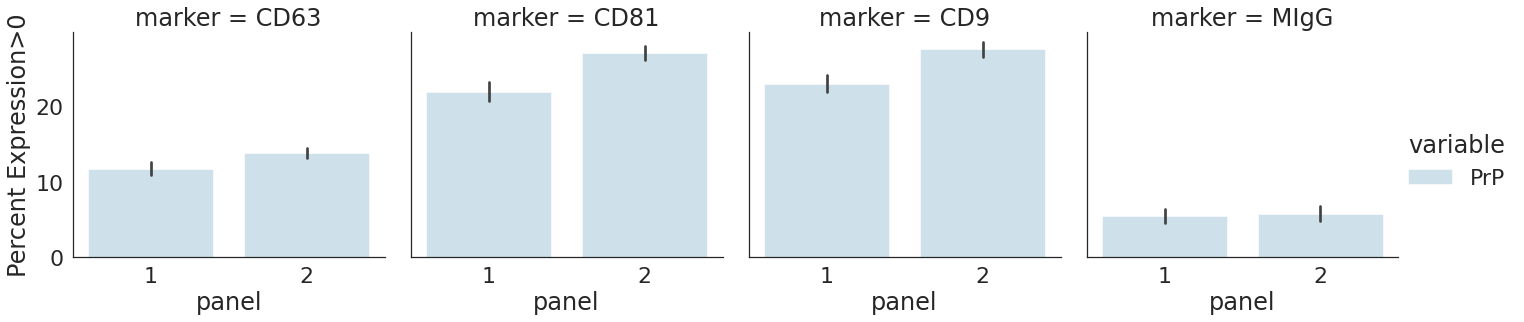

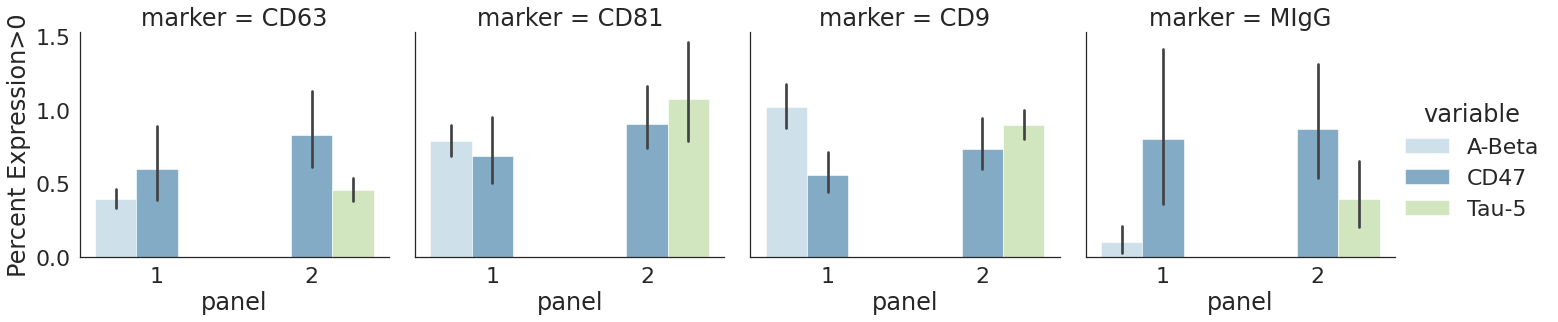

In [68]:
x="panel"
sns.set(font_scale=2, style="white")
y="Percent Expression>0"
df_plt.rename({"value":y}, axis=1, inplace=True)
g = sns.catplot(
    data=df_plt.loc[df_plt.variable=='PrP', :], 
    kind="bar",
    x=x, y=y, hue="variable",col="marker",#col_wrap=2,
    palette="Paired", alpha=.6, height=5, aspect=1,
    #sharex=True,
    sharey=True,
    
)
g = sns.catplot(
    data=df_plt.loc[df_plt.variable!='PrP', :], 
    kind="bar",
    x=x, y=y, hue="variable",col="marker",#col_wrap=2,
    palette="Paired", alpha=.6, height=5, aspect=1,
    #sharex=True,
    sharey=True,
    
)
# g.despine(left=True)
# g.set_axis_labels(x, "Percent Expression>0")

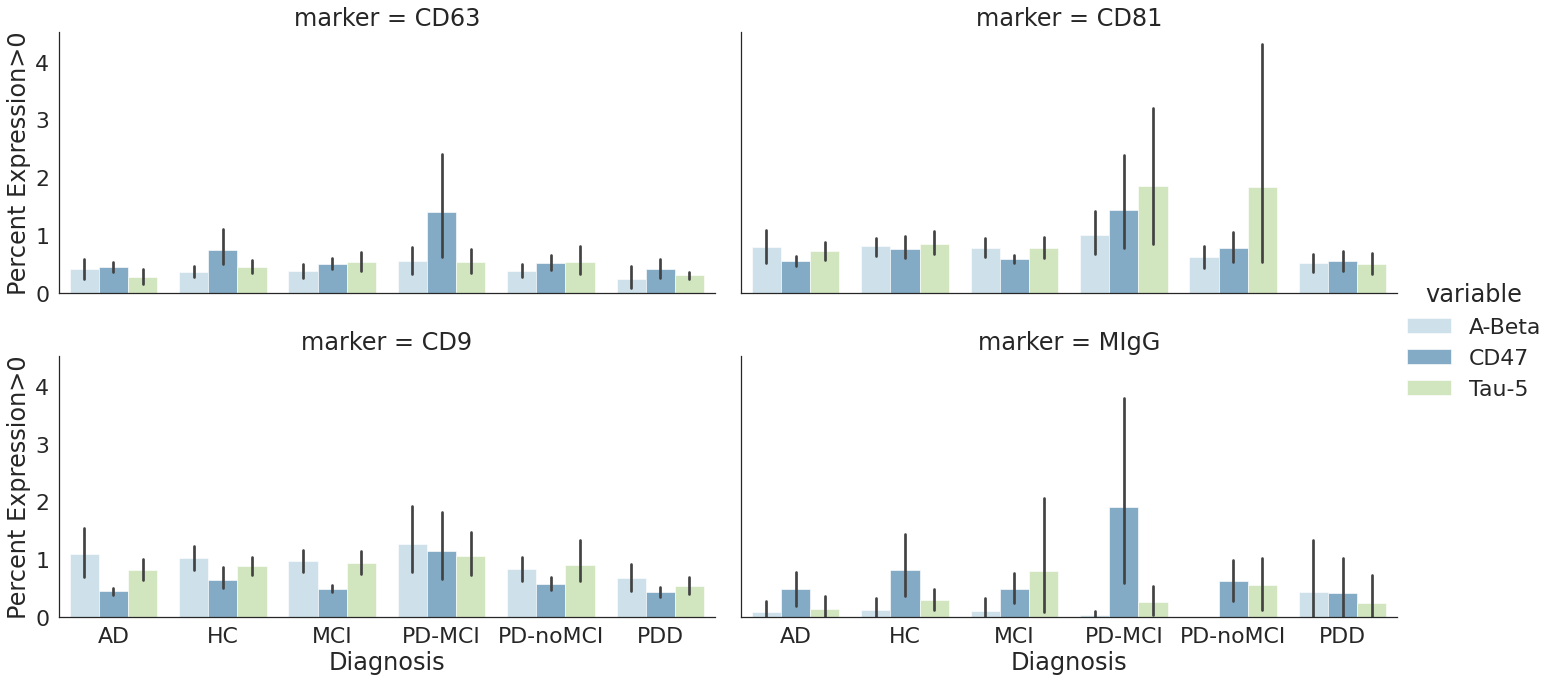

In [75]:
groupby_cols = ['Diagnosis', "panel", 'samples', "marker"]
df_plt = (df.groupby(groupby_cols)[marker].apply(lambda x: (x>0).sum())/df.groupby(groupby_cols).count().loc[:, marker]*100).reset_index()
df_plt = df_plt.melt(groupby_cols)
df_plt.head(3)
x="Diagnosis"
sns.set(font_scale=2, style="white")
y="Percent Expression>0"
df_plt.rename({"value":y}, axis=1, inplace=True)
# g = sns.catplot(
#     data=df_plt.loc[df_plt.variable=='PrP', :], 
#     kind="bar",
#     x=x, y=y, hue="variable",col="marker",#col_wrap=2,
#     palette="Paired", alpha=.6, height=5, aspect=1.5,
#     #sharex=True,
#     sharey=True,
    
# )
g = sns.catplot(
    data=df_plt.loc[df_plt.variable!='PrP', :], 
    kind="bar",
    x=x, y=y, hue="variable",col="marker",col_wrap=2,
    palette="Paired", alpha=.6, height=5, aspect=2,
    #sharex=True,
    sharey=True,
    
)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PD-MCI vs. PD-MCI: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=9.800e+01
MCI vs. PD-MCI: Mann-Whitney-Wilcoxon test two-sided, P_val:3.718e-01 U_stat=9.600e+01
PD-MCI vs. PD-noMCI: Mann-Whitney-Wilcoxon test two-sided, P_val:3.112e-01 U_stat=9.600e+01
HC vs. PD-MCI: Mann-Whitney-Wilcoxon test two-sided, P_val:2.842e-01 U_stat=1.670e+02
PD-MCI vs. PDD: Mann-Whitney-Wilcoxon test two-sided, P_val:8.703e-02 U_stat=5.400e+01
AD vs. PD-MCI: Mann-Whitney-Wilcoxon test two-sided, P_val:2.345e-01 U_stat=6.600e+01


Text(0.5, 0.98, 'CD81 / Tau-5')

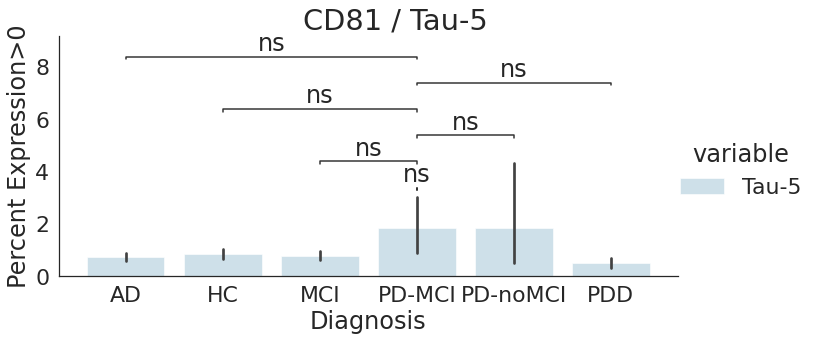

In [98]:
mark = "CD81"
var="Tau-5"
df_ = df_plt[(df_plt.marker==mark) & (df_plt.variable==var)]
x="Diagnosis"
sns.set(font_scale=2, style="white")
y="Percent Expression>0"
g = sns.catplot(
    data=df_, 
    kind="bar",
    x=x, y=y, hue="variable",#col="panel",#col_wrap=2,
    palette="Paired", alpha=.6, height=5, aspect=2,
    #sharex=True,
    sharey=True,
    
)

pairs = [("PD-MCI", i) for i in df_plt.Diagnosis.unique()]

#for name,ax in g.axes_dict.items():
if True:
        ax = g.ax
# subset the table otherwise the stats were calculated on the whole dataset
        annot = Annotator(ax, pairs, data=df_, x=x, y=y) 
        annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
        annot.apply_test().annotate()
g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle(mark +' / '+ var)

In [107]:
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
n_panel = 2
n_clusters = 4 + n_panel*4
kmeans = KMeans(
        init="random",
        n_clusters=n_clusters,
        n_init=10,
        max_iter=300,
        random_state=42
           )
cols = ['A-Beta', 'CD47', 'PrP', "Tau-5", "IM"]
kmeans.fit(df[cols].fillna(0))
clusters = kmeans.labels_
df["label"] = clusters

In [368]:
#handmade combinations
import itertools
cols = ['PrP', 'CD47','A-Beta', "Tau-5"]#, "IM"]
comb_ = []
for L in range(len(cols) + 1):
    for subset in itertools.combinations(cols, L):
        comb_.append(subset)
coloc = []
# df_def = pd.DataFrame(columns=["cluster"] +cols)
null = []
df[cols] = df[cols].astype(float)
df_ = df.fillna(0).loc[df[cols].sum(1)>0,:]
df_.reset_index(inplace=True, drop=True)
for mm in comb_:
    print(mm)
    if len(mm)>0:
        zero_mar = [it for it in cols if it not in mm]
        pos = [it for it in mm]

        if len(zero_mar)>0:
            index1 = np.where((df_[zero_mar]==0).all(axis=1))[0]
            index2 =  np.where((df_[pos]>0).all(axis=1))[0]
            index = np.intersect1d(index1,index2)
            #index = [it for it in index1 if it in index2]
        else:
            index = np.where((df_[pos]>0).all(axis=1))[0]

        tmp = df_.iloc[index,:].copy()
        
        #if len(tmp)>0:
        tmp["cluster"] = "/".join(pos) + "+"
        coloc.append(tmp)
        if len(tmp) ==0:
            null.append("/".join(pos) + "+")

()
('PrP',)
('CD47',)
('A-Beta',)
('Tau-5',)
('PrP', 'CD47')
('PrP', 'A-Beta')
('PrP', 'Tau-5')
('CD47', 'A-Beta')
('CD47', 'Tau-5')
('A-Beta', 'Tau-5')
('PrP', 'CD47', 'A-Beta')
('PrP', 'CD47', 'Tau-5')
('PrP', 'A-Beta', 'Tau-5')
('CD47', 'A-Beta', 'Tau-5')
('PrP', 'CD47', 'A-Beta', 'Tau-5')


In [369]:
ratio_def = len(df_)/len(df)
ratio_def

0.2538374142534007

In [370]:
null

['A-Beta/Tau-5+',
 'PrP/A-Beta/Tau-5+',
 'CD47/A-Beta/Tau-5+',
 'PrP/CD47/A-Beta/Tau-5+']

In [371]:
coloc_df = pd.concat(coloc)
coloc_df

,spot,A-Beta,CD47,PrP,IM,marker,samples,batch,panel,TPAD ID,Linkcode,Cohort,Diagnosis,PID 1-90,Tau-5,label,cluster
0,Spot4,0.0,0.0,624.0,50.389418,CD63,9,0,1,TPAD0491,141362,Poston,HC,9,0.0,3,PrP+
1,Spot4,0.0,0.0,491.0,55.023671,CD63,9,0,1,TPAD0491,141362,Poston,HC,9,0.0,3,PrP+
2,Spot4,0.0,0.0,503.0,51.658392,CD63,9,0,1,TPAD0491,141362,Poston,HC,9,0.0,3,PrP+
3,Spot4,0.0,0.0,614.0,53.533037,CD63,9,0,1,TPAD0491,141362,Poston,HC,9,0.0,3,PrP+
4,Spot4,0.0,0.0,467.0,50.785663,CD63,9,0,1,TPAD0491,141362,Poston,HC,9,0.0,3,PrP+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799497,Spot9,0.0,988.0,725.0,52.799865,CD9,75,5,2,TPAD0456,141162,Poston,PD-MCI,75,683.0,5,PrP/CD47/Tau-5+
799924,Spot9,0.0,904.0,925.0,55.832920,CD9,75,5,2,TPAD0456,141162,Poston,PD-MCI,75,607.0,5,PrP/CD47/Tau-5+
820229,Spot3,0.0,777.0,680.0,61.697576,CD81,30,5,2,TPAD0373,1229,ADRC,HC,30,513.0,5,PrP/CD47/Tau-5+
820639,Spot7,0.0,479.0,720.0,51.507823,CD9,30,5,2,TPAD0373,1229,ADRC,HC,30,909.0,5,PrP/CD47/Tau-5+


/tmp/ipykernel_2916853/1506386790.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar_ax.set_yticklabels(['0', '1'])


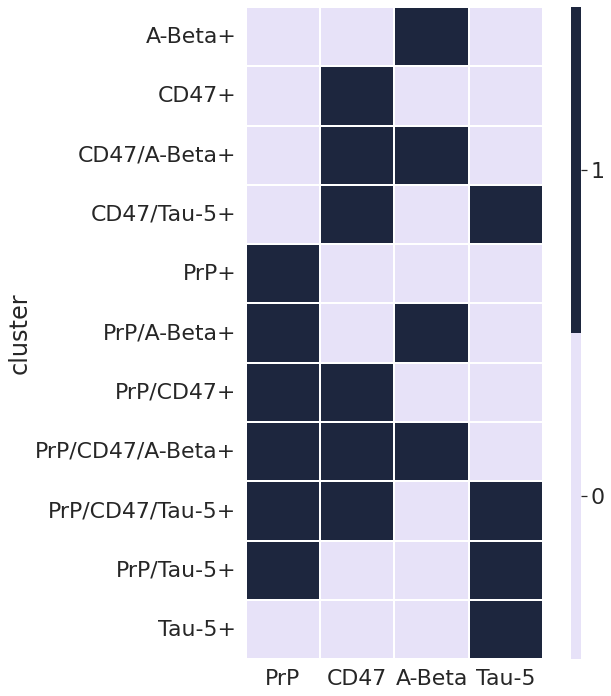

In [376]:
from matplotlib.colors import ListedColormap
mat = coloc_df[cols+["cluster"]].groupby(["cluster"]).mean()
mat[mat>0] = 1
cmap = sns.cubehelix_palette(start=2.8, rot=.1, light=0.9, n_colors=2)
grid_kws = {'width_ratios': (0.9, 0.03), 'wspace': 0.18}
fig, (ax, cbar_ax) = plt.subplots(1, 2, figsize=(6, 12), gridspec_kw=grid_kws)
sns.heatmap(mat, cmap=ListedColormap(cmap), ax=ax,cbar_ax=cbar_ax,linewidth=0.2)
cbar_ax.set_yticklabels(['0', '1'])
cbar_ax.yaxis.set_ticks([ 0.25, 0.75])

Text(0.5, 1.0, 'Distribution of the single exomes')

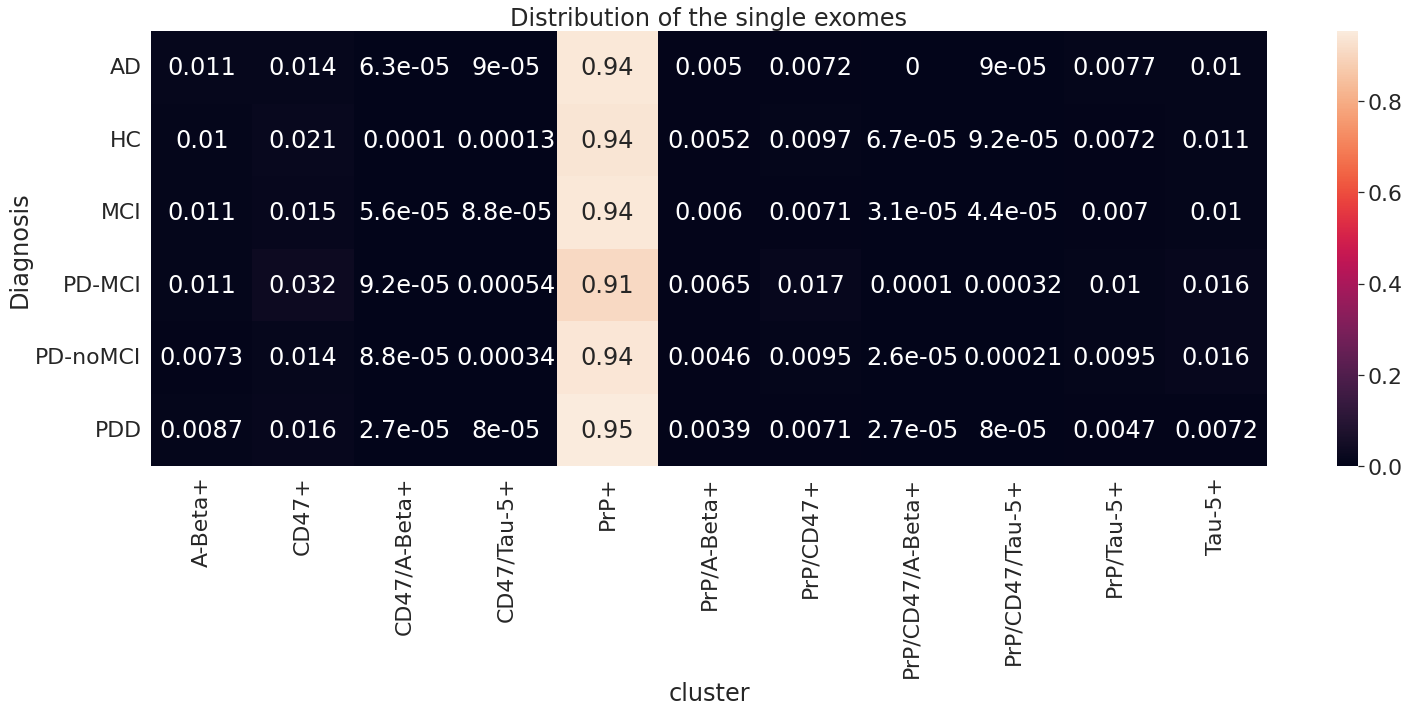

In [378]:
repart = coloc_df.groupby(["cluster", "Diagnosis"]).size().unstack().fillna(0)
repart = repart.div(repart.sum(0), axis=1)
fig, ax = plt.subplots(figsize=(25, 8))
sns.heatmap(repart.T, #.drop("PrP+", axis=1),
            annot=True, ax=ax)
ax.set_title("Distribution of the single exomes")

In [361]:
mean_express = coloc_df.groupby(["cluster", "Diagnosis", "samples"])["IM"].mean()#.unstack().fillna(0)


df_plot = coloc_df.reset_index().groupby(["cluster", "Diagnosis", "samples"])[cols].mean().reset_index().melt(["cluster", "Diagnosis", "samples"]).fillna(0)
y = "Mean expression"
df_plot.rename({"value":y}, inplace=True, axis=1)
df_plot[y].replace([np.inf, -np.inf], 0, inplace=True)
df_plot[y] = df_plot[y].astype(float)



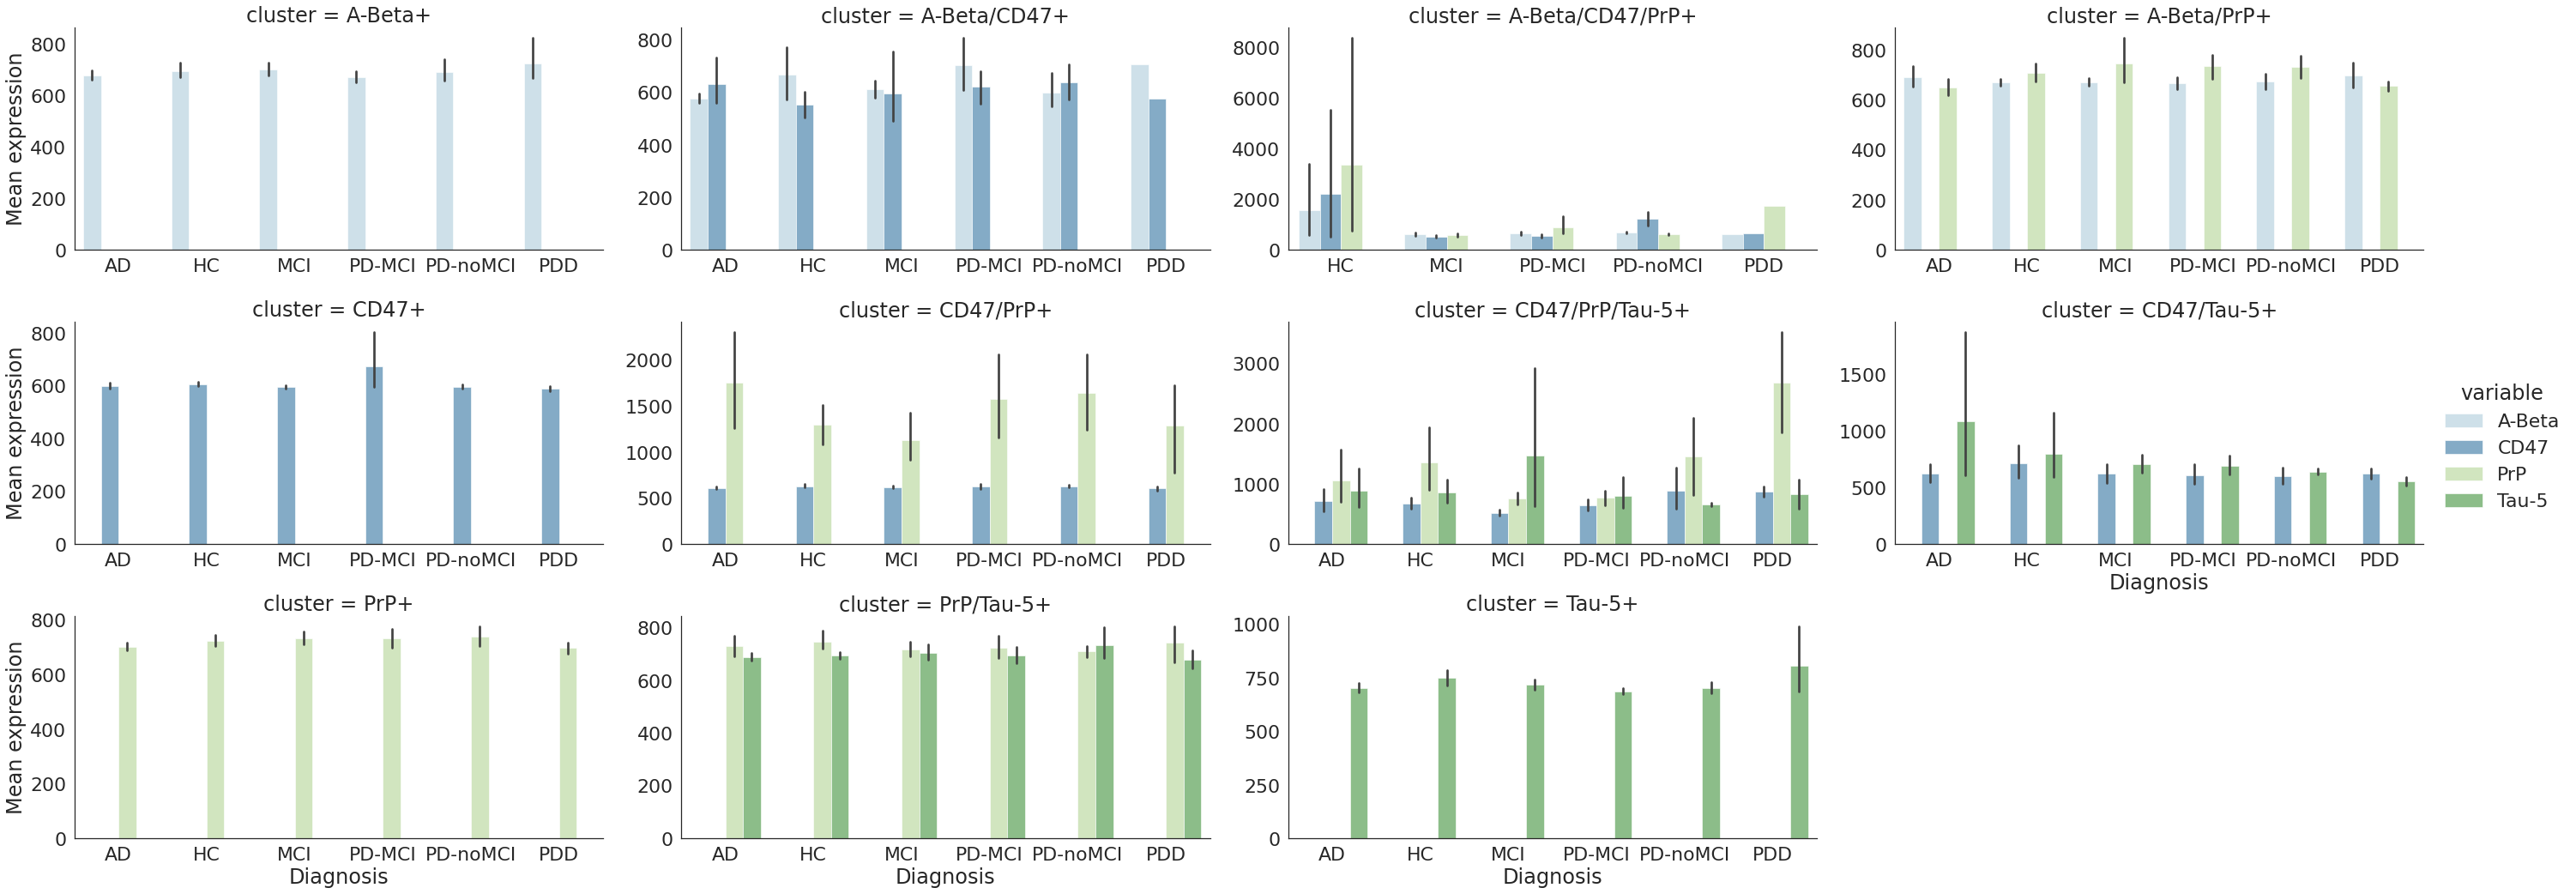

In [362]:
g = sns.catplot(
    data=df_plot, #.loc[df_plt.variable!='PrP', :],
    kind="bar",
    x="Diagnosis", y=y, hue="variable",col="cluster",
    col_wrap=4,sharex=False, sharey=False,
    palette="Paired", alpha=.6, height=5, aspect=2,
)
# g.despine(left=True)
# pairs = [(("MCI", "Tau-5"),( i, "Tau-5")) for i in df_plt.Diagnosis.unique() if i != "MCI"]
# pairs =[]
# for name,ax in g.axes_dict.items():
#     if name =="CD47/PrP/Tau-5+":
#         pairs = [(("MCI", "Tau-5"),( i, "Tau-5")) for i in df_plt.Diagnosis.unique() if i != "MCI"]
#     # elif name =="A-Beta/CD47/PrP+":
#     #     pairs = [(("HC", "Tau-5"),( i, "Tau-5")) for i in df_plt.Diagnosis.unique() if i != "AD"]
#     if len(pairs)>0:
#         print(name)
# # subset the table otherwise the stats were calculated on the whole dataset
#         annot = Annotator(ax, pairs, data=df_plot, x=x, y=y, hue="variable") 
#         annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
#         annot.apply_test().annotate()
#         pairs=[]

In [345]:
df_plot

,cluster,Diagnosis,samples,variable,Mean expression
0,A-Beta+,AD,31,index,202871.835821
1,A-Beta+,AD,32,index,351755.562500
2,A-Beta+,AD,33,index,238725.538462
3,A-Beta+,AD,34,index,193525.605634
4,A-Beta+,AD,35,index,226851.569106
...,...,...,...,...,...
6187,Tau-5+,PDD,61,label,5.000000
6188,Tau-5+,PDD,62,label,5.000000
6189,Tau-5+,PDD,63,label,5.000000
6190,Tau-5+,PDD,64,label,5.000000
